In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import matplotlib.colors as colors
from sklearn.utils import resample

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.ensemble import GradientBoostingClassifier

In [4]:
import distribution_modules as dm
import density_estimation_modules as dem
import importlib

importlib.reload(dm)
importlib.reload(dem)

<module 'density_estimation_modules' from 'C:\\Users\\shfar\\Desktop\\SU\\Thesis\\thesis\\density_estimation_modules.py'>

In [5]:
bounded_dists = dm.get_bounded_distribution()
bounded_dists

{'arcsine': <scipy.stats._distn_infrastructure.rv_frozen at 0x282b2b87d30>,
 'beta_1_2': <scipy.stats._distn_infrastructure.rv_frozen at 0x282b2b87ac0>,
 'powerlaw_0.3': <scipy.stats._distn_infrastructure.rv_frozen at 0x282b8079100>,
 'trapezoid_0.3_0.8': <scipy.stats._distn_infrastructure.rv_frozen at 0x282b8079460>,
 'traing_0.3': <scipy.stats._distn_infrastructure.rv_frozen at 0x282b8079700>,
 'uniform': <scipy.stats._distn_infrastructure.rv_frozen at 0x282b8079b50>}

In [7]:
 x = np.linspace(0,1,10)
kde_df = dem.get_kde_estimates(bounded_dists, nr_sample=20, sample_size=500, x_values=10, bandwidth=0.05)
# automatic bandwidth

In [188]:
kde_df

,0,1,2,3,4,5,6,7,8,9,dist
0,1.346214,1.046419,0.813306,0.585716,0.579143,0.785951,0.757053,0.655444,1.247591,1.110549,arcsine
1,1.311733,1.233937,0.902536,0.661682,0.555646,0.456053,0.578634,0.813041,1.157203,1.254859,arcsine
2,1.118955,1.278795,0.825667,0.629431,0.660723,0.493558,0.683196,0.749295,1.113787,1.361705,arcsine
3,1.314110,1.171818,0.694561,0.519194,0.568116,0.653628,0.710080,0.760060,1.215654,1.314904,arcsine
4,1.389872,1.295783,0.848488,0.592875,0.651913,0.691425,0.714286,0.752189,0.991937,1.011874,arcsine
...,...,...,...,...,...,...,...,...,...,...,...
115,0.442799,0.986425,1.000170,1.164705,0.839730,0.985635,1.000785,0.985709,1.057587,0.507837,uniform
116,0.534365,1.086693,0.959788,0.943630,0.855961,1.160082,1.030278,0.997154,0.929788,0.478869,uniform
117,0.505135,1.015594,0.943506,1.037202,1.157158,1.055943,0.960193,1.059273,0.821365,0.436113,uniform
118,0.470768,0.895983,0.901362,0.988237,1.061747,0.860685,1.000592,1.192886,0.995581,0.598426,uniform


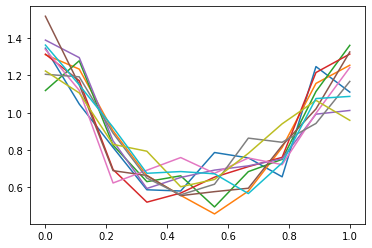

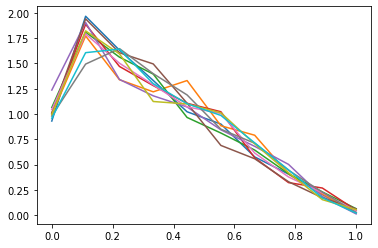

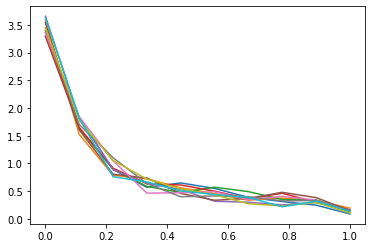

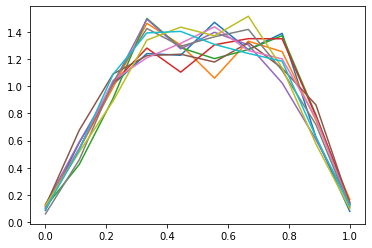

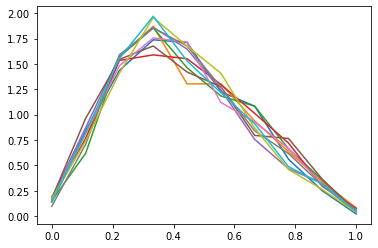

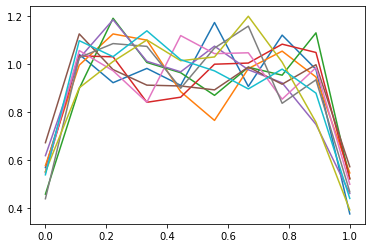

In [184]:
for name,distr in (bounded_dists.items()):
    fig, ax = plt.subplots()
    temp = kde_df.loc[kde_df['dist']==name]
    for i in range(10):
        y = temp.iloc[i]
        y = y[0:10] # use drop instead
        x = np.linspace(0,1,10)

        ax.plot(x,y)   

In [115]:
def prepare_data(df, test_size):
    X = df.drop('dist', axis=1)
    y = df['dist']
    
    # Scaling data
    scaler = StandardScaler()
    scaler.fit(X)
    X_scaled = scaler.transform(X)

    # train-test split
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size = test_size, random_state=11)
    return X, y, X_train, X_test, y_train, y_test

In [163]:
def svm_model(X, y, X_train, X_test, y_train, y_test, cv):
    param_grid = [
        {'C':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10],
         'gamma':[0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1, 5, 10], 
         'kernel':['rbf']},
    ]

    optimal_params = GridSearchCV(SVC(), param_grid,cv=5, verbose=0)
    optimal_params.fit(X_train, y_train)

    clf_svm = SVC(random_state=10, C=optimal_params.best_params_['C'], gamma=optimal_params.best_params_['gamma'])
    clf_svm.fit(X_train, y_train)

    y_pred = clf_svm.predict(X_test)
    scores = cross_val_score(clf_svm, X, y, cv=cv)
    accuracy = scores.mean()
    
    return y_pred, accuracy, scores

In [162]:
X, y, X_train, X_test, y_train, y_test = prepare_data(kde_df, 0.2)
svm_model(X, y, X_train, X_test, y_train, y_test, 5)

(array(['traing_0.3', 'arcsine', 'uniform', 'traing_0.3', 'arcsine',
        'trapezoid_0.3_0.8', 'arcsine', 'arcsine', 'powerlaw_0.3',
        'beta_1_2', 'arcsine', 'beta_1_2', 'beta_1_2', 'trapezoid_0.3_0.8',
        'traing_0.3', 'trapezoid_0.3_0.8', 'traing_0.3', 'uniform',
        'traing_0.3', 'powerlaw_0.3', 'beta_1_2', 'arcsine',
        'trapezoid_0.3_0.8', 'trapezoid_0.3_0.8'], dtype=object),
 1.0,
 array([1., 1., 1., 1., 1.]))

In [166]:
bandwidth = [0.001, 0.005, 0.01, 0.05, 0.1, 0.5, 1]
for i in bandwidth:
    kde_df = modules.get_kde_estimates(bounded_dists, 20, 500, 10, b)
    X, y, X_train, X_test, y_train, y_test = prepare_data(kde_df, 0.2)
    a, b, c = svm_model(X, y, X_train, X_test, y_train, y_test, 5)
    print(b)
    print(c)

1.0
[1. 1. 1. 1. 1.]
1.0
[1. 1. 1. 1. 1.]
1.0
[1. 1. 1. 1. 1.]
1.0
[1. 1. 1. 1. 1.]
1.0
[1. 1. 1. 1. 1.]
1.0
[1. 1. 1. 1. 1.]
1.0
[1. 1. 1. 1. 1.]


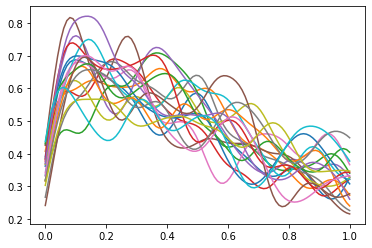

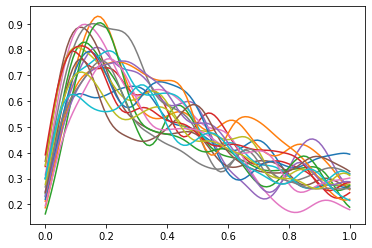

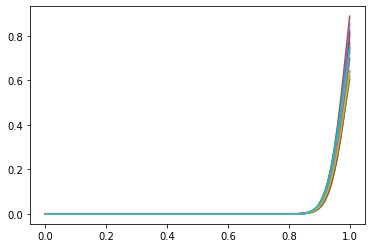

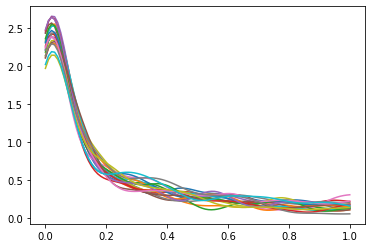

In [178]:
longtail_dists = modules.get_longtail_distribution()
kde_df = modules.get_kde_estimates(longtail_dists, nr_sample=20, s_size=500, x_values=100, bandwidth=0.05)
for name,distr in (longtail_dists.items()):
    fig, ax = plt.subplots()
    temp = kde_df.loc[kde_df['dist']==name]
    for i in range(20):
        y = temp.iloc[i]
        y = y[0:100]
        x = np.linspace(0,1,100)

        ax.plot(x,y)  

In [176]:
kde_df

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,dist
0,0.361868,0.423374,0.482420,0.536306,0.582847,0.620638,0.649177,0.668847,0.680741,0.686396,...,0.269599,0.263813,0.261448,0.263027,0.268883,0.279032,0.293051,0.310018,0.328557,cauchy
1,0.407846,0.457829,0.500163,0.533389,0.557311,0.572949,0.582240,0.587560,0.591192,0.594882,...,0.314978,0.319110,0.320835,0.319562,0.315100,0.307649,0.297710,0.285966,0.273155,cauchy
2,0.319407,0.361173,0.397911,0.427955,0.450322,0.464827,0.472105,0.473528,0.471038,0.466915,...,0.393886,0.398473,0.400200,0.398309,0.392519,0.383068,0.370631,0.356133,0.340510,cauchy
3,0.377713,0.432120,0.481059,0.522165,0.553887,0.575678,0.588032,0.592374,0.590840,0.585979,...,0.270874,0.273323,0.278641,0.285938,0.294214,0.302533,0.310186,0.316782,0.322259,cauchy
4,0.392480,0.452544,0.510791,0.565535,0.615362,0.659120,0.695886,0.724927,0.745701,0.757896,...,0.361091,0.365086,0.367751,0.368058,0.365375,0.359558,0.350941,0.340227,0.328329,cauchy
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
75,2.108098,2.239863,2.311957,2.324093,2.282120,2.196497,2.080102,1.945912,1.805080,1.665746,...,0.176650,0.179879,0.182093,0.183086,0.182804,0.181331,0.178840,0.175544,0.171660,weibull_min_0.4
76,2.246153,2.356014,2.395142,2.365315,2.275620,2.140464,1.976811,1.801312,1.627955,1.466646,...,0.192688,0.192340,0.193777,0.197046,0.202008,0.208344,0.215581,0.223124,0.230279,weibull_min_0.4
77,2.135856,2.248837,2.296534,2.280118,2.207587,2.092005,1.948987,1.794049,1.640395,1.497534,...,0.065418,0.063941,0.062562,0.061429,0.060639,0.060229,0.060201,0.060544,0.061268,weibull_min_0.4
78,1.972357,2.088326,2.145937,2.144758,2.090272,1.992565,1.864400,1.719144,1.569013,1.423874,...,0.128423,0.130877,0.132942,0.134589,0.135948,0.137295,0.138999,0.141415,0.144782,weibull_min_0.4


In [179]:
X, y, X_train, X_test, y_train, y_test = prepare_data(kde_df, 0.2)
svm_model(X, y, X_train, X_test, y_train, y_test, 5)

(array(['cauchy', 'cauchy', 'pareto_1.5', 'pareto_1.5', 'weibull_min_0.4',
        'weibull_min_0.4', 'weibull_min_0.4', 'lognorm_1.5', 'cauchy',
        'cauchy', 'cauchy', 'cauchy', 'weibull_min_0.4', 'lognorm_1.5',
        'weibull_min_0.4', 'pareto_1.5'], dtype=object),
 0.9125,
 array([0.9375, 0.9375, 1.    , 0.8125, 0.875 ]))